# 0.) Load libraries/datasets

In [1]:
# Load libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re # I think I'm addicted to regex
import seaborn as sns

from itertools import product
from os.path import isfile

from sklearn.metrics import accuracy_score, auc, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

sns.set(style='ticks', color_codes=True)

# Load dataset
data_path = './datasets/creditcard.csv'
df = pd.DataFrame()
if not isfile(data_path):
    print("Dataset not found. Please check that the dataset exists and the path is correct.")
else:
    df = pd.read_csv(data_path)

# 1.) Pre-process

In [2]:
# Overview of the data
display(df)
display(df.describe())
display(df.columns)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [3]:
# Nulls? Nope.
display(df.isnull().sum().max())

0

In [4]:
# Duplicates? Yes.
display(df[df.duplicated()])
display(df[df.duplicated()]['Class'].value_counts())
df.drop_duplicates(inplace=True, ignore_index=True)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282987,171288.0,1.912550,-0.455240,-1.750654,0.454324,2.089130,4.160019,-0.881302,1.081750,1.022928,...,-0.524067,-1.337510,0.473943,0.616683,-0.283548,-1.084843,0.073133,-0.036020,11.99,0
283483,171627.0,-1.464380,1.368119,0.815992,-0.601282,-0.689115,-0.487154,-0.303778,0.884953,0.054065,...,0.287217,0.947825,-0.218773,0.082926,0.044127,0.639270,0.213565,0.119251,6.82,0
283485,171627.0,-1.457978,1.378203,0.811515,-0.603760,-0.711883,-0.471672,-0.282535,0.880654,0.052808,...,0.284205,0.949659,-0.216949,0.083250,0.044944,0.639933,0.219432,0.116772,11.93,0
284191,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,...,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0


0    1062
1      19
Name: Class, dtype: int64

In [5]:
# Make copy of current df in case of later need
df_processed = df.copy()

### Confusion

I watched the part of the office hours where you talk about Standardization and Normalization but I'm still confused as to why we would need it on this dataset. As such, I'm only going to standardize 'Amount.' I seem to get approximately similar results this way based on the other office hours video.

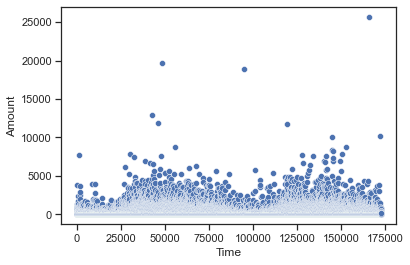

Mean: 88.47268731099724
STD: 250.39899584557298


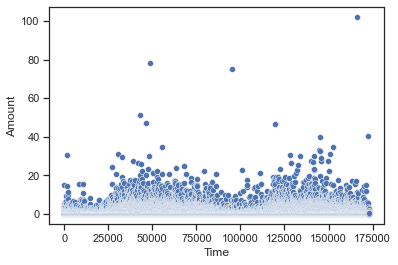

Mean: -5.409346726214081e-17
STD: 1.0


In [6]:
# Standardize Amount
# Show scatterplot of Amount (displot would be prefered but . . . I'm stupid)
sns.scatterplot(y=df['Amount'], x=df['Time'])
plt.show()

print(f"Mean: {np.mean(df['Amount'])}")
print(f"STD: {np.std(df['Amount'])}")

# High number of outliers based on stats, so let's use RobustScaler
scaler = StandardScaler()

df_scaled = df.copy()
df_scaled.drop(columns=['Amount'], inplace=True)

df_scaled['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))

# Show new plot and stats
sns.scatterplot(y=df_scaled['Amount'], x=df_scaled['Time'])
plt.show()

print(f"Mean: {np.mean(df_scaled['Amount'])}")
print(f"STD: {np.std(df_scaled['Amount'])}")

In [7]:
# Drop Time (doesn't encode data we're interested in)
df_scaled.drop(columns=['Time'], inplace=True)

In [8]:
# Set df_scaled to df for own sanity
df = df_scaled.copy()

# Save some memory
df_scaled = None 

# 2.) Check the class balance and pick an evaluation metric.

The classes are very highly unbalanced. 

The Kaggle page for this dataset recognizes this imbalance and recommends Area Under the Precision-Recall Curve (AUPRC) as the evaluation metric, but SVC with probabilities takes forever. In light of this I'm going with just the F1 Score which was giving me similar results but doesn't slow the training to a crawl.

0    283253
1       473
Name: Class, dtype: int64

C:\Users\whm00\miniconda3\envs\AML\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


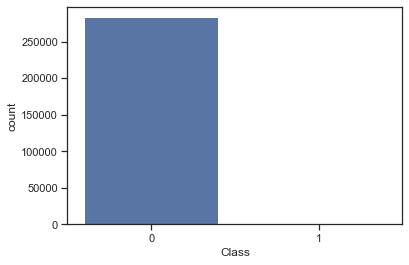

In [9]:
# Class Balance. Very unbalanced
display(df['Class'].value_counts())

sns.countplot('Class', data=df)
plt.show()

# 3.) Split 50-50 and run DecisionTreeClassifier, SVC, MLPClassifier without any tree pruning or regularization.

In [10]:
# Split labels and data
X = df.loc[:, df.columns != 'Class'].values
Y = df.loc[:, df.columns == 'Class'].values.ravel()

# Define Unregularized Models
Models = [DecisionTreeClassifier(), SVC(1e5), MLPClassifier(alpha=0.0)]

C:\Users\whm00\miniconda3\envs\AML\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass C=100000.0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [11]:
# Define how to run and score the models
# Partially adapted from:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
def run_models(models, x=X, y=Y, test_size=0.5):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=test_size)

    scores = {}
    
    # Run train and test
    for model in models:
        print(f"Running {model}") # SVC w/ probability is slow
        model = model.fit(x_train, y_train)
        
        #y_probs = model.predict_proba(x_test)[:, 1]
        y_pred = model.predict(x_test)
        
        #precision, recall, _ = precision_recall_curve(y_test, y_probs, pos_label=1)
        #auprc = auc(recall, precision)
        
        f1 = f1_score(y_test, y_pred) # per office hours
        
        accuracy = accuracy_score(y_test, y_pred)
        
        scores[model] = accuracy, f1
        
    return scores

# Make the scores readable
def pretty_print_scores(scores):
    name_exp = r'([A-Za-z]+)\(.*\)'
    for model in scores:
        name = re.match(name_exp, str(model))
        name = name.group(1)
        
        accuracy, f1 = scores[model]
        
        print(f'\n{name}:')
        print(f'\tAccuracy: {accuracy}')
        print(f'\tf1 Score: {f1}')
        #print(f'\tAUPRC: {auprc}')

In [12]:
%%time
# Run models and report score metrics
un_scores = run_models(Models)
pretty_print_scores(un_scores)

Running DecisionTreeClassifier()
Running SVC(C=100000.0)
Running MLPClassifier(alpha=0.0)

DecisionTreeClassifier:
	Accuracy: 0.9990342795513982
	f1 Score: 0.727634194831014

SVC:
	Accuracy: 0.9988580531921643
	f1 Score: 0.6197183098591548

MLPClassifier:
	Accuracy: 0.9995418114659919
	f1 Score: 0.853932584269663
Wall time: 53.5 s


# 4.) Run with tree pruning and regularization.

In [13]:
# Get data for this part
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y,
                                                    test_size=0.5, random_state=42)

# Method for running GridSearchCV
def do_search(model, parameters, x=X, y=Y, verbose=True):
    search = GridSearchCV(model, parameters, scoring='f1', n_jobs=8)
    search.fit(x, y)
    
    if verbose:
        print(f'Best {model} regularization parameter: {search.best_params_}')
        
    return search.best_score_

In [14]:
%%time
tree_parameters = {'ccp_alpha': [1/10**i for i in range(3, 8)]}
do_search(DecisionTreeClassifier(), tree_parameters)

Best DecisionTreeClassifier() regularization parameter: {'ccp_alpha': 1e-05}
Wall time: 1min 30s


0.7738606587391832

In [15]:
%%time
svc_parameters = {'C': [5, 10, 15, 20, 25]}
do_search(SVC(), svc_parameters)

Best SVC() regularization parameter: {'C': 5}
Wall time: 11min 35s


0.5952655932315611

In [16]:
%%time
mlp_parameters = {'alpha': [1/10**i for i in range(1, 5)]}
do_search(MLPClassifier(), mlp_parameters)

Best MLPClassifier() regularization parameter: {'alpha': 0.1}
Wall time: 2min 9s


0.8096732866866324

# 5.) Attempt avoiding overfitting while the training is reduced.

I should have read through the assigment a little more to help myself with this part, but I think this will be doable.

I first ran this with GridSearchCV for each training size but I was getting the same best parameters for each, so I modified my method and just used the 'best' parameters to save time.

In [17]:
# Put regularizable models and their parameters in a dict
reg_models = [DecisionTreeClassifier(ccp_alpha=1e-05),
              SVC(C=5),
              MLPClassifier(alpha=0.1)]

def gather(test_sizes, reg_models=reg_models, un_models=Models):
    name_exp = r'([A-Za-z]+)\(.*\)'
    
    reg_scores = {}
    un_scores = {}
    
    for test_size in test_sizes:
        these_reg_scores = run_models(reg_models, test_size=test_size)
        for model in reg_models:
            # get model name (copy-paste. boooooo, I stink)            
            name = re.match(name_exp, str(model))
            name = name.group(1)
            
            # if model not in reg_scores, add it w/ empty list
            if name not in reg_scores:
                reg_scores[name] = []
                
            # add best score from GridSearch to dict
            reg_scores[name].append(these_reg_scores[model][1])
            
        these_un_scores = run_models(un_models, test_size=test_size)
        for model in these_un_scores:
            
            # get model name (copy-paste. boooooo, I stink)          
            name = re.match(name_exp, str(model))
            name = name.group(1)
            
            if name not in un_scores:
                un_scores[name] = []
                
            un_scores[name].append(these_un_scores[model][1])
            
    return reg_scores, un_scores

In [18]:
test_sizes = [i/10 for i in range(5, 10)]
test_sizes.append(0.95)

reg_scores, un_scores = gather(test_sizes)

display(reg_scores)
display(un_scores)

Running DecisionTreeClassifier(ccp_alpha=1e-05)
Running SVC(C=5)
Running MLPClassifier(alpha=0.1)
Running DecisionTreeClassifier()
Running SVC(C=100000.0)
Running MLPClassifier(alpha=0.0)
Running DecisionTreeClassifier(ccp_alpha=1e-05)
Running SVC(C=5)
Running MLPClassifier(alpha=0.1)
Running DecisionTreeClassifier()
Running SVC(C=100000.0)
Running MLPClassifier(alpha=0.0)
Running DecisionTreeClassifier(ccp_alpha=1e-05)
Running SVC(C=5)
Running MLPClassifier(alpha=0.1)
Running DecisionTreeClassifier()
Running SVC(C=100000.0)
Running MLPClassifier(alpha=0.0)
Running DecisionTreeClassifier(ccp_alpha=1e-05)
Running SVC(C=5)
Running MLPClassifier(alpha=0.1)
Running DecisionTreeClassifier()
Running SVC(C=100000.0)
Running MLPClassifier(alpha=0.0)
Running DecisionTreeClassifier(ccp_alpha=1e-05)
Running SVC(C=5)
Running MLPClassifier(alpha=0.1)
Running DecisionTreeClassifier()
Running SVC(C=100000.0)
Running MLPClassifier(alpha=0.0)
Running DecisionTreeClassifier(ccp_alpha=1e-05)
Running SVC(

{'DecisionTreeClassifier': [0.7820224719101124,
  0.7829313543599258,
  0.7543581616481775,
  0.6799468791500665,
  0.6495726495726495,
  0.6496424923391215],
 'SVC': [0.8077858880778589,
  0.7695473251028807,
  0.7286245353159851,
  0.6382252559726962,
  0.5193548387096774,
  0.48208469055374586],
 'MLPClassifier': [0.8400000000000001,
  0.8022598870056497,
  0.8077544426494347,
  0.8308115543328749,
  0.8251231527093597,
  0.796116504854369]}

{'DecisionTreeClassifier': [0.724,
  0.7357859531772575,
  0.6862442040185471,
  0.6905940594059405,
  0.6517150395778365,
  0.5308370044052864],
 'SVC': [0.4733475479744136,
  0.4186915887850467,
  0.4070796460176991,
  0.5572413793103448,
  0.49922480620155035,
  0.24390243902439027],
 'MLPClassifier': [0.8282352941176471,
  0.8233082706766918,
  0.8080808080808081,
  0.8207282913165266,
  0.776566757493188,
  0.6880856760374833]}

# 6.) Results

As can be seen in the results applying Regularization to these models appears to have allowed them to be much more robust even with lower amounts of training data. When the unregularized models receive smaller amounts of data, f1 scores drop much harder than the regularized models (even if those models may not be using ideal regularization parameters).

I think I may have hampered myself somewhat by not more diligently applying Standardization even if my results are similar, as your plots in the office hours video seem to show these results in a clearer fashion. Or maybe I should have been patient with GridSearchCV when gathering the scores in the code cell above.

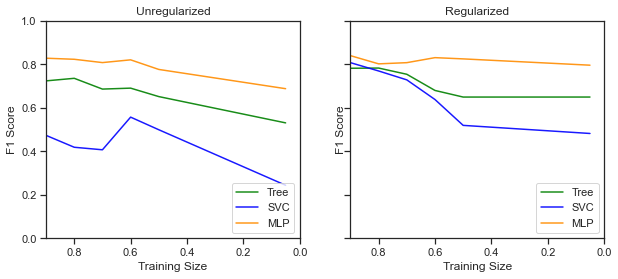

In [23]:
trains = [i/10 for i in range(9, 4, -1)]
trains.append(0.05)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axs[0].plot(trains, un_scores['DecisionTreeClassifier'], c='green', alpha=0.9, label='Tree')
axs[0].plot(trains, un_scores['SVC'], c='blue', alpha=0.9, label='SVC')
axs[0].plot(trains, un_scores['MLPClassifier'], c='darkorange', alpha=0.9, label='MLP')
axs[0].set_xlabel('Training Size')
axs[0].set_ylabel('F1 Score')
axs[0].set_xlim(max(trains), 0)
axs[0].set_ylim(0, 1)
axs[0].legend(loc='lower right')
axs[0].set_title('Unregularized')


axs[1].plot(trains, reg_scores['DecisionTreeClassifier'], c='green', alpha=0.9, label='Tree')
axs[1].plot(trains, reg_scores['SVC'], c='blue', alpha=0.9, label='SVC')
axs[1].plot(trains, reg_scores['MLPClassifier'], c='darkorange', alpha=0.9, label='MLP')
axs[1].set_xlabel('Training Size')
axs[1].set_ylabel('F1 Score')
axs[1].set_xlim(max(trains), 0)
axs[1].set_ylim(0, 1)
axs[1].legend(loc='lower right')
axs[1].set_title('Regularized')

plt.show()